# Проект "Промышленность"

**Цель проекта:**

Оптимизация производственных расходов на металлургическом комбинате ООО «Так закаляем сталь» посредством уменьшения потребления электроэнергии на этапе обработки стали. 

Необходимо построить модель, которая предскажет температуру стали.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_arc = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_arc_new.csv') # данные об электродах
df_arc.name = 'Данные об электродах'
df_bulk = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_bulk_new.csv') # данные о подаче сыпучих материалов (объём)
df_bulk.name = 'Данные о подаче сыпучих материалов (объём)'
df_bulk_time = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_bulk_time_new.csv') # данные о подаче сыпучих материалов (время)
df_bulk_time.name = 'Данные о подаче сыпучих материалов (время)'
df_gas = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_gas_new.csv') # данные о продувке сплава газом
df_gas.name = 'Данные о продувке сплава газом'
df_temp = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_temp_new.csv') # результаты измерения температуры
df_temp.name = 'Результаты измерения температуры'
df_wire = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_wire_new.csv') # данные о проволочных материалах (объём)
df_wire.name = 'Данные о проволочных материалах (объём)'
df_wire_time = pd.read_csv('/Users/evgen/OneDrive/Рабочий стол/Моя новая профессия/Выпускной/data_wire_time_new.csv') # данные о проволочных материалах (время)
df_wire_time.name = 'Данные о проволочных материалах (время)'

In [3]:
data = [df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time]
for i in data:
    print(f'Таблица: {i.name}')
    display(i.head())
    print(100 * '-')
    print(i.info())
    print(100 * '-')
    print('Дубликаты', i.duplicated().sum())
    print(100 * '-')
    print('Пропуски')
    print(i.isna().sum().sort_values(ascending=False))
    print(100 * '-')
    print('Количество этапов')
    print(i['key'].unique())
    print(100 * '-')
    print('Разброс данных')
    pd.set_option('display.max_columns', None)
    display(i.describe().round(2))
    print(127 * '*-')

Таблица: Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------------------------------------------------------------------
Дубликаты 0
----------------------------------------------------------------------------------------------------
Пропуски
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.66,0.44
std,934.57,0.26,5.87
min,1.00,0.22,-715.48
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
max,3241.00,1.46,1.27


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
--------------------------------------------------

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
--------------------------------------------------------------------

,key
count,3129.00
mean,1624.38
std,933.34
min,1.00
25%,816.00
50%,1622.00
75%,2431.00
max,3241.00


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------------------------------------------------------------------------------------
Дубликаты 0
----------------------------------------------------------------------------------------------------
Пропуски
key      0
Газ 1    0
dtype: int64
----------------------------------------------------------------------------------------------------
Количество этапов
[   1    2    3 ... 3239 3240 3241]
----------------------------------------------------------------------------------------------------
Разброс данных


,key,Газ 1
count,3239.00,3239.00
mean,1621.86,11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,1622.00,9.84
75%,2431.50,13.77
max,3241.00,78.00


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
----------------------------------------------------------------------------------------------------
Дубликаты 0
----------------------------------------------------------------------------------------------------
Пропуски
Температура     3427
key                0
Время замера       0
dtype: int64
----------------------------------------------------------------------------------------------------
Количество этапов
[   1    2    3 ... 3239 3240 3241]
-----------------------------------------------------

,key,Температура
count,18092.00,14665.00
mean,1616.46,1590.72
std,934.64,20.39
min,1.00,1191.00
25%,807.75,1580.00
50%,1618.00,1590.00
75%,2429.00,1599.00
max,3241.00,1705.00


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
----------------------------------------------------------------------------------------------------
Дубликаты 0
----------------------------------------------------------------------------------------------------
Пропуски
Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9  

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Таблица: Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
----------------------------------------------------------------------------------------------------
Дубликаты 0
----------------------------------------------------------------------------------------------------
Пропуски
Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 

,key
count,3081.00
mean,1623.43
std,933.00
min,1.00
25%,823.00
50%,1619.00
75%,2434.00
max,3241.00


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


### Посмотрим данные по одному ключу

In [4]:
for i in data:
    display(i.loc[i['key'] == 1])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43


,key,Газ 1
0,1,29.749986


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Во всех датафреймах есть все партии.

Есть пропуски в датафреймах  о данных о подаче сыпучих материалов (Bulk) и данных о проволочных материалах (Wire), что является нормальным т.к для разных химических составов начальной стали необходимо различное кол-во этапов легирования. Соответственно пропуски заполним нулями.

Данные на первый взгляд распределены нормально. Кроме реактивной мощности. Есть отрицательные значения. Расммотрим подробнее.

Данные о времени подачи дополнительных материалов нам не несут необходимой информации. Их не берем в расчет.

## Исследовательский анализ

### Данные об электродах

In [5]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


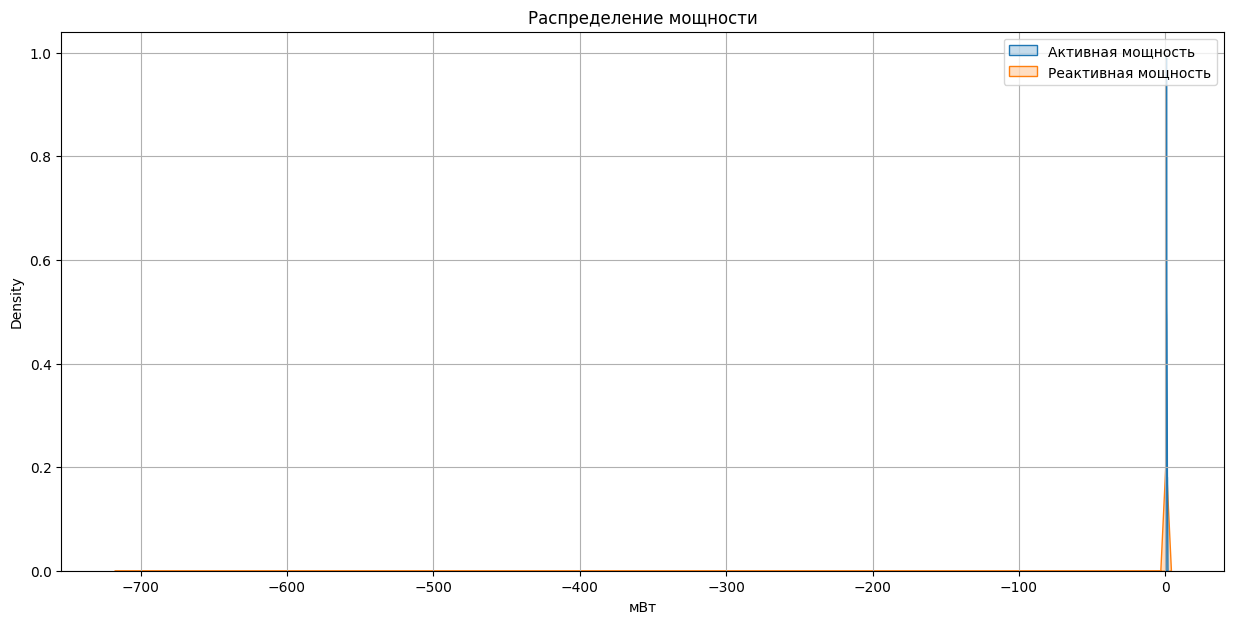

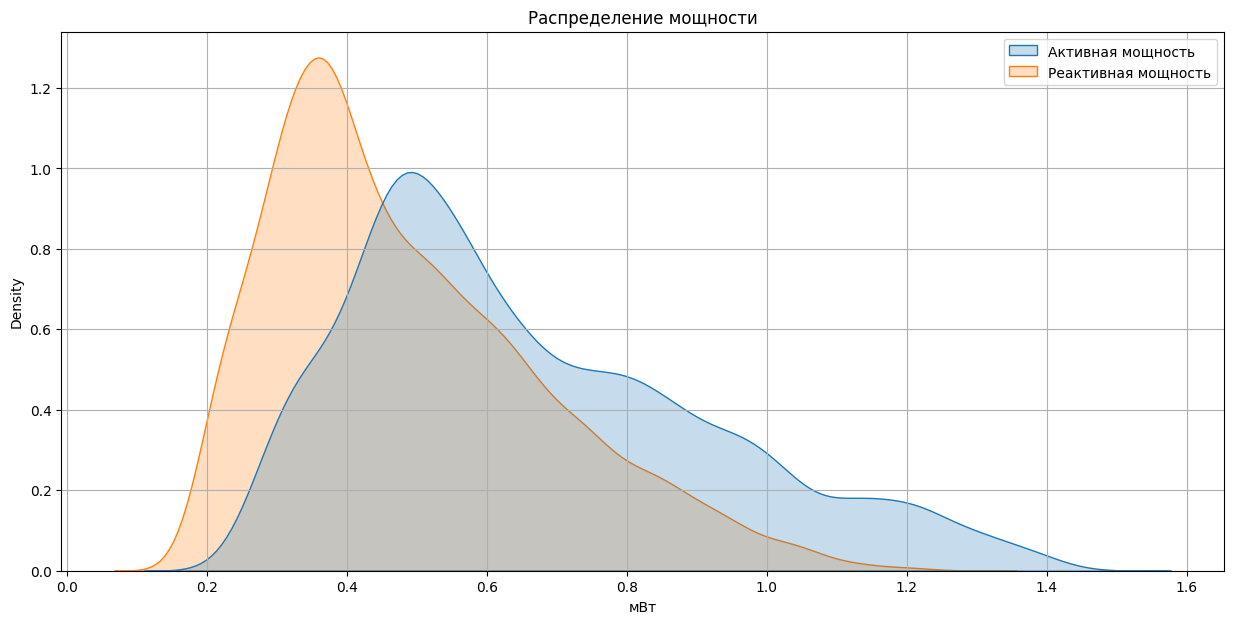

In [6]:
plt.figure(figsize=(15, 7))
sns.kdeplot(data = df_arc.drop(['key'], axis=1), fill=True)
plt.grid(True)
plt.title('Распределение мощности')
plt.xlabel('мВт')
plt.show()
plt.figure(figsize=(15, 7))
sns.kdeplot(data = df_arc.drop(['key'], axis=1).loc[df_arc['Реактивная мощность'] >= 0], fill=True)
plt.grid(True)
plt.title('Распределение мощности')
plt.xlabel('мВт')
plt.show()

Как мы видим у реактивной мощности наблюдаются ***выбросы ввиде отрицательных значений***. На втором графике отрицательные значения исключены и мы видим равномерное распределение данных.

### Данные о подаче допольнительных материалах

Перед тем как рассмотреть данные подаче доп материалов заполним пропуски нулями.

In [7]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)

In [8]:
display(df_bulk.describe().round())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0,3129.0
mean,1624.0,3.0,2.0,47.0,34.0,3.0,22.0,2.0,0.0,0.0,5.0,4.0,204.0,1.0,153.0,115.0
std,933.0,12.0,21.0,74.0,56.0,21.0,55.0,32.0,1.0,6.0,20.0,23.0,151.0,14.0,81.0,84.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,104.0,0.0
50%,1622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,148.0,106.0
75%,2431.0,0.0,0.0,80.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,0.0,202.0,204.0
max,3241.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


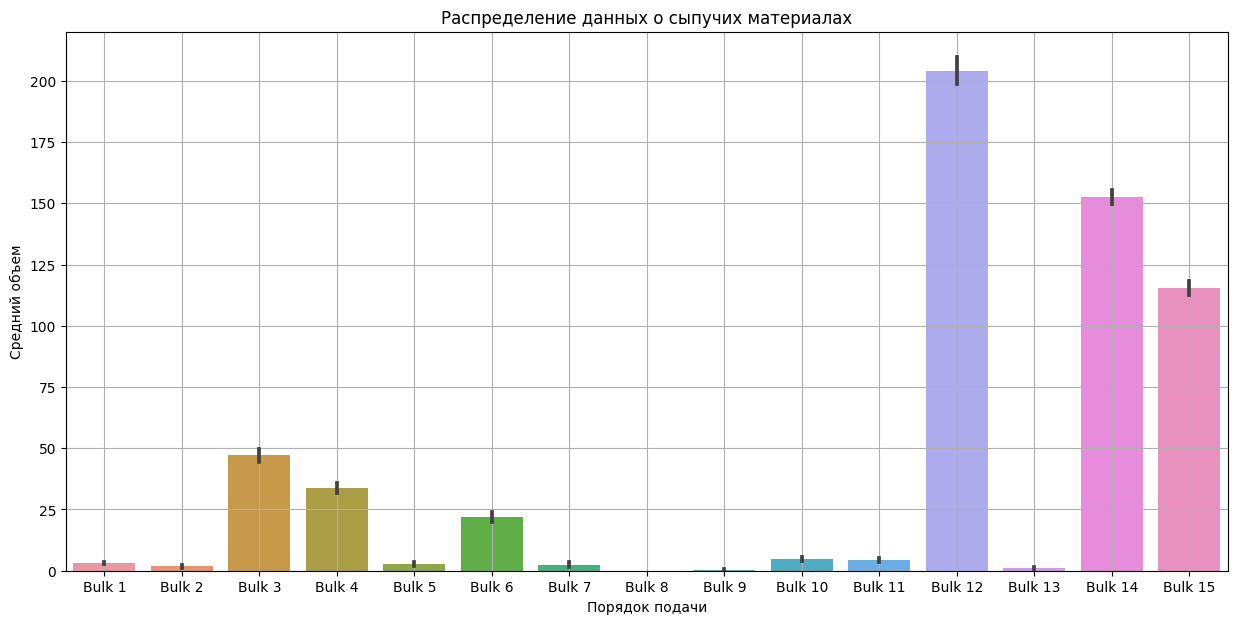

In [9]:
plt.figure(figsize=(15, 7))
sns.barplot(data = df_bulk.drop(['key'], axis=1))
plt.grid(True)
plt.title('Распределение данных о сыпучих материалах')
plt.xlabel('Порядок подачи')
plt.ylabel('Средний объем')
plt.show()

In [10]:
display(df_wire.describe().round())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.0,3081.0,3081.0,3081.0,3081.0,3081.0,3081.0,3081.0,3081.0,3081.0
mean,1623.0,100.0,18.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
std,933.0,43.0,34.0,30.0,4.0,0.0,9.0,1.0,4.0,4.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,823.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1619.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,2434.0,126.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3241.0,330.0,283.0,385.0,113.0,15.0,180.0,33.0,103.0,90.0


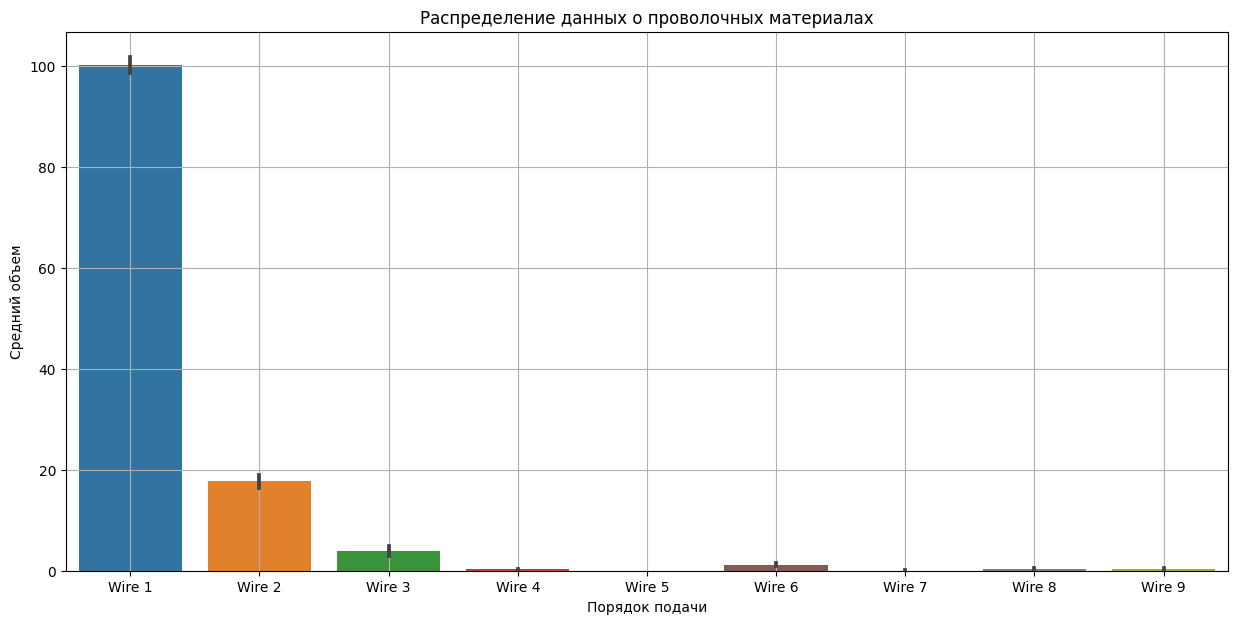

In [11]:
plt.figure(figsize=(15, 7))
sns.barplot(data = df_wire.drop(['key'], axis=1))
plt.grid(True)
plt.title('Распределение данных о проволочных материалах')
plt.xlabel('Порядок подачи')
plt.ylabel('Средний объем')
plt.show()

Распределение по добавкам ***нормальное***. Как мы видим в начале процесса преобладают добавки проволочного материала, а под конец процесса больше добавляют сыпучих материалов.

### Данные о подаче газа

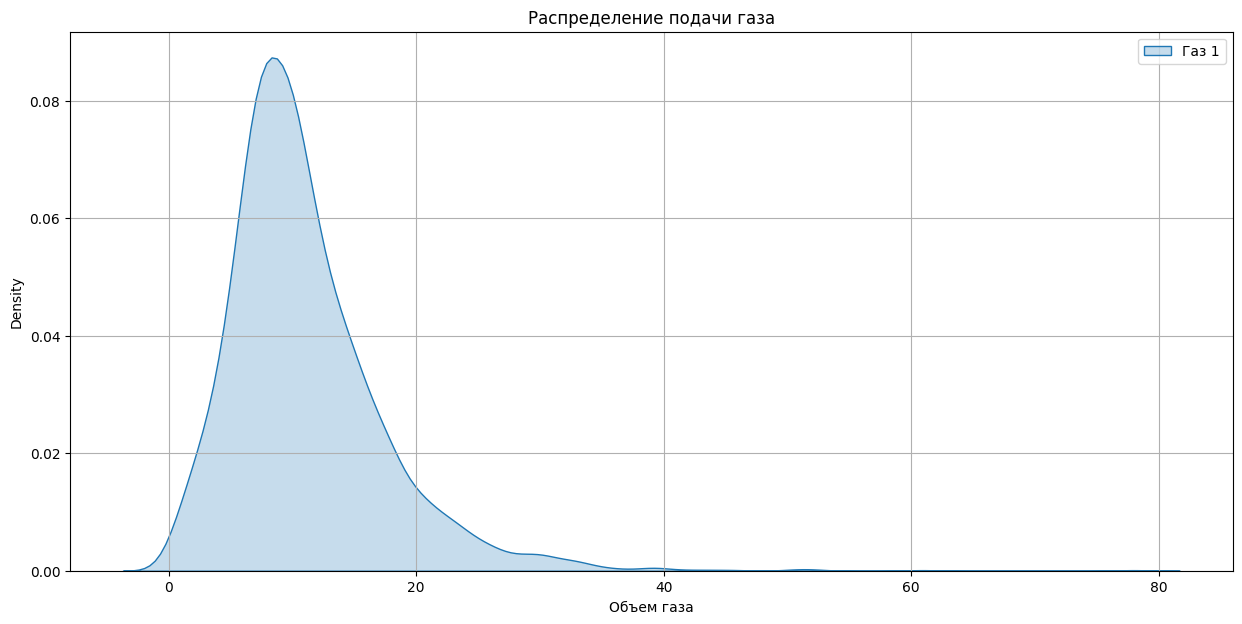

In [12]:
plt.figure(figsize=(15, 7))
sns.kdeplot(data=df_gas.drop(['key'], axis=1), fill=True)
plt.grid(True)
plt.title('Распределение подачи газа')
plt.xlabel('Объем газа')
plt.show()

Данные распределены ***нормально***.

### Данные о температуре

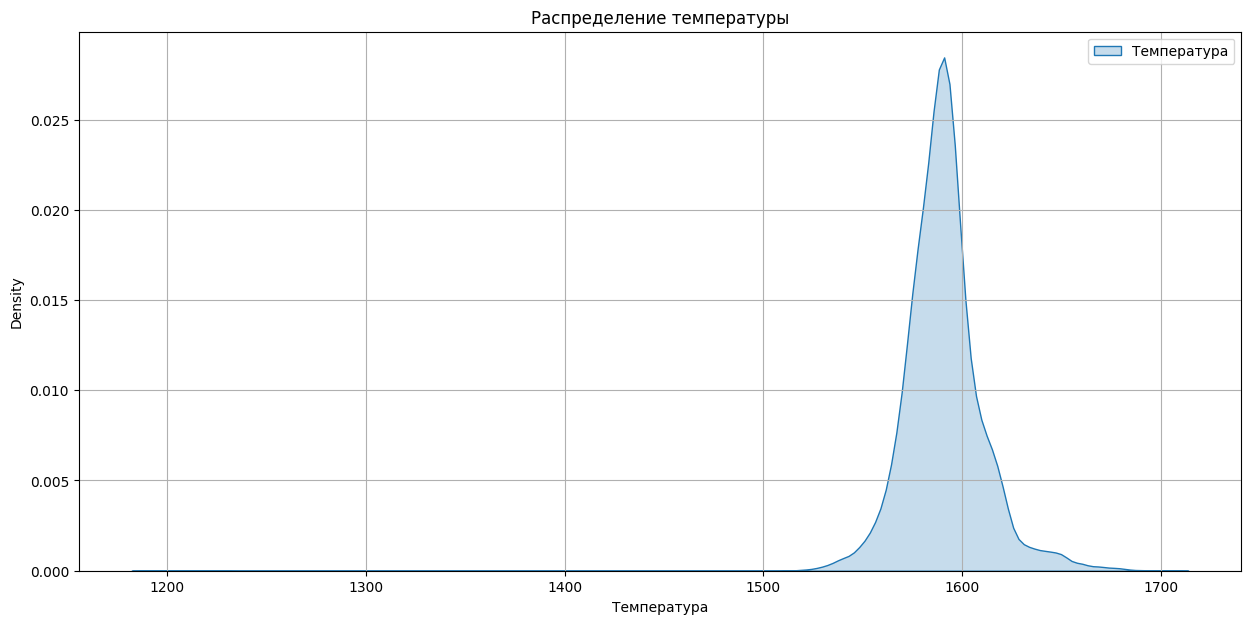

In [13]:
plt.figure(figsize=(15, 7))
sns.kdeplot(data=df_temp.drop(['key'], axis=1), fill=True)
plt.grid(True)
plt.title('Распределение температуры')
plt.xlabel('Температура')
plt.show()

***Температура ниже 1500*** у нас быть не должно соотвественно эти данные мы ***исключаем***. Дальнейшее распределение данных нормальное.

***Примерный план решения задачи:***

1. Проводим предобработку данных. Обьединяем данные, удаляем ненужные признаки. Суммируем данные о добавляемых материалах. Усредняем полную мощность. 


2. Разделяем на выборки. Обучающая и тестовая. 


3. Выбираем модель. Несколько (не менее трех) моделей проверяем кросс валидацией и выбираем по лучшей метрике.


4. Проводим тестирование модели.

## Предобработка данных

Создаем функцию для групировки по ключу

In [14]:
def key(data, aggfunc):
    data_new = data.pivot_table(index='key', aggfunc=aggfunc)
    return data_new

### Обработка данных об электродах

Удаляем отрицательную мощность

In [15]:
df_arc = df_arc.loc[df_arc['Реактивная мощность'] >= 0]
df_arc.describe().round(2)

,key,Активная мощность,Реактивная мощность
count,14875.00,14875.00,14875.00
mean,1615.19,0.66,0.49
std,934.59,0.26,0.20
min,1.00,0.22,0.15
25%,806.00,0.47,0.34
50%,1617.00,0.60,0.44
75%,2429.00,0.83,0.61
max,3241.00,1.46,1.27


Переводим столбцы с временем к формату datetime и считаем время в секундах на каждый замер

In [16]:
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Время'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Время'] = df_arc['Время'].dt.total_seconds()
display(df_arc.head(10))


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


По формуле считаем ***полную мощность***.

In [17]:
df_arc = df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
df_arc['Полная мощность'] = ((df_arc['Активная мощность'] ** 2) + (df_arc['Реактивная мощность'] ** 2))**0.5
df_arc 

,key,Активная мощность,Реактивная мощность,Время,Полная мощность
0,1,0.305130,0.211253,228.0,0.371123
1,1,0.765658,0.477438,185.0,0.902319
2,1,0.580313,0.430460,172.0,0.722536
3,1,0.518496,0.379979,365.0,0.642824
4,1,0.867133,0.643691,148.0,1.079934
...,...,...,...,...,...
14871,3241,0.439735,0.299579,157.0,0.532085
14872,3241,0.646498,0.458240,180.0,0.792429
14873,3241,1.039726,0.769302,184.0,1.293389
14874,3241,0.530267,0.361543,57.0,0.641792


Группируем по ключам.

In [18]:
df_arc_new = key(df_arc, 'mean')
df_arc_new.head()

,Активная мощность,Время,Полная мощность,Реактивная мощность
key,,,,
1,0.607346,219.60,0.743747,0.428564
2,0.534852,202.75,0.647087,0.363339
3,0.812728,131.00,1.003845,0.587491
4,0.676622,185.25,0.850010,0.514248
5,0.563238,217.25,0.704245,0.421998


In [19]:
df_arc_new = df_arc.pivot_table(index='key', values=['Полная мощность', 'Активная мощность',
                                                    'Реактивная мощность'], aggfunc=['sum', 'first', 'last', 'mean'])
df_arc_new.columns= ['Сумма активной мощности', 'Сумма полной мощности', 'Сумма реактивной мощности', 
                     'Начальная активная мощность', 'Начальная полная мощность', 'Начальная реактивная мощность', 
                     'Последняя активная мощность', 'Последняя полная мощность', 'Последняя реактивная мощность', 
                     'Средняя активная мощность', 'Средняя полная мощность', 'Средняя реактивная мощность']
df_arc_new = df_arc_new.reset_index()
df_arc_new = df_arc_new.set_index('key')
df_arc_new['Общее время'] = df_arc.pivot_table(index='key', values=['Время'], aggfunc='sum')
df_arc_new.head()

,Сумма активной мощности,Сумма полной мощности,Сумма реактивной мощности,Начальная активная мощность,Начальная полная мощность,Начальная реактивная мощность,Последняя активная мощность,Последняя полная мощность,Последняя реактивная мощность,Средняя активная мощность,Средняя полная мощность,Средняя реактивная мощность,Общее время
key,,,,,,,,,,,,,
1,3.036730,3.718736,2.142821,0.305130,0.371123,0.211253,0.867133,1.079934,0.643691,0.607346,0.743747,0.428564,1098.0
2,2.139408,2.588349,1.453357,0.381124,0.440239,0.220351,0.786322,0.955315,0.542517,0.534852,0.647087,0.363339,811.0
3,4.063641,5.019223,2.937457,1.101678,1.373863,0.820856,0.421693,0.502111,0.272562,0.812728,1.003845,0.587491,655.0
4,2.706489,3.400038,2.056992,0.642946,0.824445,0.516071,0.864995,1.084803,0.654661,0.676622,0.850010,0.514248,741.0
5,2.252950,2.816980,1.687991,0.324563,0.428064,0.279102,0.892957,1.110873,0.660807,0.563238,0.704245,0.421998,869.0


### Данные о температуре

In [20]:
df_temp.query('Температура <= 1500') # данные с выбросами ниже 1500 

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [21]:
df_temp_new = df_temp.pivot_table(index='key', values='Температура', aggfunc=['sum', 'count', 'first', 'last', 'mean'])
df_temp_new.columns=['Сумма температур', 'Количество замеров', 'Начальная температура', 'Последняя температура',
                     'Средняя температура']
df_temp_new = df_temp_new.reset_index()
df_temp_new = df_temp_new.drop(index=[867, 1214, 1619, 2052, 2561]) # удаляем данные по ключам где замеры ниже 1500
df_temp_new = df_temp_new.loc[df_temp_new['Количество замеров'] > 1] # удаляем данные с одним замером температуры
df_temp_new = df_temp_new.set_index('key')
df_temp_new.head()

,Сумма температур,Количество замеров,Начальная температура,Последняя температура,Средняя температура
key,,,,,
1,9613.0,6,1571.0,1613.0,1602.166667
2,7953.0,5,1581.0,1602.0,1590.600000
3,9589.0,6,1596.0,1599.0,1598.166667
4,8084.0,5,1601.0,1625.0,1616.800000
5,7945.0,5,1576.0,1602.0,1589.000000


### Данные о добавлении газа

In [22]:
df_gas_new = key(df_gas, 'sum')
df_gas_new.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Данные о дополнительных добавках

In [23]:
df_bulk_new = df_bulk.pivot_table(index='key', aggfunc='sum')
df_bulk_new['sum_bulk'] = df_bulk_new.loc[:, 'Bulk 1' : 'Bulk 9'].apply(lambda x: x.sum(), axis=1)
display(df_bulk_new.head())

,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,sum_bulk
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,553.0
2,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,582.0
3,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,544.0
4,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,595.0
5,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,584.0


In [24]:
df_wire_new = df_wire.pivot_table(index='key', aggfunc='sum')
df_wire_new['sum_wire'] = df_wire_new.loc[:, 'Wire 1' : 'Wire 9'].apply(lambda x: x.sum(), axis=1)
df_wire_new.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### Объединение данных

In [25]:
df = df_arc_new.join([df_temp_new, df_gas_new, df_bulk_new, df_wire_new], how='inner')
display(df.head())
print(df.shape)

,Сумма активной мощности,Сумма полной мощности,Сумма реактивной мощности,Начальная активная мощность,Начальная полная мощность,Начальная реактивная мощность,Последняя активная мощность,Последняя полная мощность,Последняя реактивная мощность,Средняя активная мощность,Средняя полная мощность,Средняя реактивная мощность,Общее время,Сумма температур,Количество замеров,Начальная температура,Последняя температура,Средняя температура,Газ 1,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.036730,3.718736,2.142821,0.305130,0.371123,0.211253,0.867133,1.079934,0.643691,0.607346,0.743747,0.428564,1098.0,9613.0,6,1571.0,1613.0,1602.166667,29.749986,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,553.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,2.139408,2.588349,1.453357,0.381124,0.440239,0.220351,0.786322,0.955315,0.542517,0.534852,0.647087,0.363339,811.0,7953.0,5,1581.0,1602.0,1590.600000,12.555561,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,582.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,4.063641,5.019223,2.937457,1.101678,1.373863,0.820856,0.421693,0.502111,0.272562,0.812728,1.003845,0.587491,655.0,9589.0,6,1596.0,1599.0,1598.166667,28.554793,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,544.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,2.706489,3.400038,2.056992,0.642946,0.824445,0.516071,0.864995,1.084803,0.654661,0.676622,0.850010,0.514248,741.0,8084.0,5,1601.0,1625.0,1616.800000,18.841219,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,595.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,2.252950,2.816980,1.687991,0.324563,0.428064,0.279102,0.892957,1.110873,0.660807,0.563238,0.704245,0.421998,869.0,7945.0,5,1576.0,1602.0,1589.000000,5.413692,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,584.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


(2325, 45)


### Проверка на мультиколлениарность

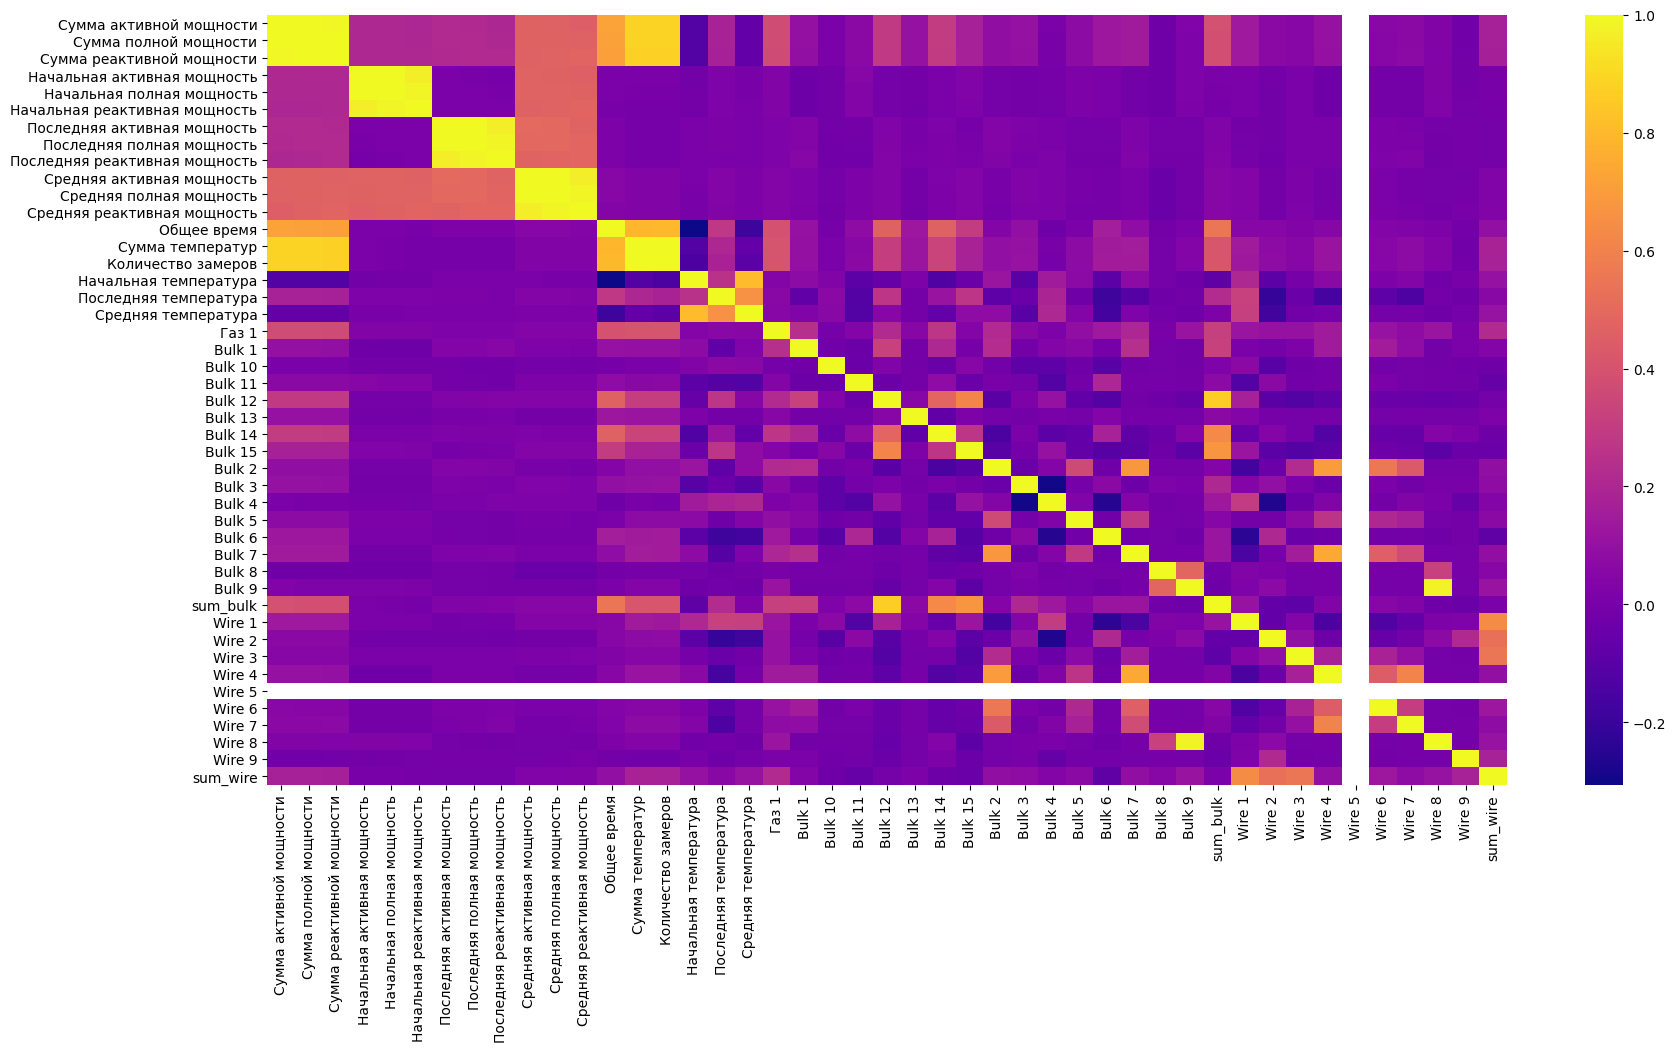

In [26]:
plt.figure(figsize=(20,10))
df_plot = sns.heatmap(df.corr(), cmap='plasma')
plt.show()

Как мы видим на целевой признак "Последняя температура" значительное влияние имеет "Средняя температура" что может привести к утечке. Также к утечке может привести "Сумма температур", т.к сумма температур включает в себя и "Последнюю температуру".

## Выбор модели

In [27]:
RANDOM_STATE = 240423

### Разделение на выборки

In [28]:
features = df.drop(['Средняя температура','Последняя температура', 'Сумма температур'], axis=1)
target = df['Последняя температура']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state = RANDOM_STATE)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)
features_train.head()

(1743, 42) (582, 42) (1743,) (582,)


,Сумма активной мощности,Сумма полной мощности,Сумма реактивной мощности,Начальная активная мощность,Начальная полная мощность,Начальная реактивная мощность,Последняя активная мощность,Последняя полная мощность,Последняя реактивная мощность,Средняя активная мощность,Средняя полная мощность,Средняя реактивная мощность,Общее время,Количество замеров,Начальная температура,Газ 1,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420,4.436097,5.492642,3.227030,0.467712,0.554300,0.297480,0.693018,0.855466,0.501546,0.739349,0.915440,0.537838,706.0,7,1598.0,14.244007,0.0,0.0,0.0,255.0,0.0,128.0,218.0,0.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,694.0,181.350006,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,181.350006
407,2.671697,3.317154,1.963766,0.545224,0.666839,0.383934,0.425129,0.516529,0.293373,0.534339,0.663431,0.392753,973.0,6,1554.0,16.194449,0.0,0.0,0.0,103.0,0.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,359.0,129.261596,108.515679,279.783508,0.0,0.0,0.0,0.0,0.0,0.0,517.560783
488,2.648081,3.290917,1.952491,1.234620,1.519820,0.886321,0.447490,0.544638,0.310457,0.882694,1.096972,0.650830,486.0,4,1621.0,7.093691,0.0,0.0,0.0,185.0,0.0,168.0,205.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,599.0,92.149200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,92.149200
2345,4.210660,5.215188,3.068283,0.413352,0.493328,0.269281,0.993393,1.237434,0.737843,0.842132,1.043038,0.613657,641.0,6,1633.0,1.912122,0.0,0.0,0.0,156.0,0.0,140.0,104.0,0.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,494.0,80.371200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,80.371200
1400,4.203397,5.277278,3.166753,1.099629,1.308779,0.709732,1.096640,1.498810,1.021671,0.700566,0.879546,0.527792,1250.0,7,1527.0,10.655252,0.0,0.0,0.0,410.0,0.0,205.0,204.0,0.0,172.0,0.0,0.0,0.0,0.0,0.0,0.0,991.0,135.064804,70.212479,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,205.277283


### Линейная регрессия

In [29]:
%%time
model = LinearRegression()
result = abs(cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')).mean()
print(f'LinearRegression: MAE {result:.2f}')

LinearRegression: MAE 6.86
CPU times: total: 46.9 ms
Wall time: 110 ms


### Случайный лес

Подбор гиперпараметров для случайного леса с помощью GridSearchCV

In [30]:
%%time
model_f = RandomForestRegressor(random_state=RANDOM_STATE, criterion='mae')
param = {'max_depth':[3,5,10,None],
         'n_estimators':[10,10,200],
         'max_features':[1,3,5,7]}
grid = GridSearchCV(model_f, param_grid=param, cv=3, scoring='neg_mean_absolute_error')
model_grid = grid.fit(features_train, target_train)
print(f'Лучшие гиперпараметры: {str(model_grid.best_params_)}')
print(f'Лучшая оценка: {model_grid.best_score_:.2f}')

Лучшие гиперпараметры: {'max_depth': None, 'max_features': 7, 'n_estimators': 200}
Лучшая оценка: -6.77
CPU times: total: 3min 21s
Wall time: 5min 24s


In [31]:
model_f = RandomForestRegressor(n_estimators=200, max_depth=None, max_features=7, random_state=RANDOM_STATE, 
                                criterion='mae')
model_f.fit(features_train, target_train)
predicted_f = model_f.predict(features_test)
mae = mean_absolute_error(target_test, predicted_f)
print(f'RandomForestRegressor: MAE {mae:.2f}')

RandomForestRegressor: MAE 6.62


### CatBoost

Подбор гиперпараметров для CatBoost с помощью GridSearchCV

In [32]:
%%time
model_cat = CatBoostRegressor(verbose=False, eval_metric = 'MAE')
param = {'iterations':[500, 1000, 1500, 2000],
         'learning_rate':[0.01, 0.02, 0.03, 0.04]}
grid = GridSearchCV(model_cat, param_grid=param, cv=3, scoring='neg_mean_absolute_error')
model_grid = grid.fit(features_train, target_train)
print(f'Лучшие гиперпараметры: {str(model_grid.best_params_)}')
print(f'Лучшая оценка: {model_grid.best_score_:.2f}')

Лучшие гиперпараметры: {'iterations': 500, 'learning_rate': 0.03}
Лучшая оценка: -6.20
CPU times: total: 16min 54s
Wall time: 10min 42s


In [33]:
model_cat = CatBoostRegressor(iterations = 500, learning_rate=0.03, verbose=False, eval_metric = 'MAE')
result_cat = cross_val_score(model_cat, features_train, target_train, cv=5, scoring = 'neg_mean_absolute_error').mean() * -1
print(f'CatBoost: MAE {result_cat:.2f}')

CatBoost: MAE 6.14


***Результаты:***
- LinearRegression: MAE 6.86
- RandomForestRegressor: MAE 6.62
- CatBoost: MAE 6.14

Выбираем модель градиентного бустинга ***CatBoost с гиперпараметрами: {'iterations': 500, 'learning_rate': 0.03}***

## Тестирование

In [34]:
model = CatBoostRegressor(iterations = 500, learning_rate=0.03,  verbose=False, eval_metric = 'MAE')
model.fit(features_train, target_train)
predict = model.predict(features_test)
mae = mean_absolute_error(target_test, predict)
print(f'ТЕСТ CatBoost: MAE {mae:.2f}')

ТЕСТ CatBoost: MAE 6.25


Выбранная модель на тесте дает хороший результат. ТЕСТ CatBoost: MAE 6.25


## Отчет 



### Цель проекта:

Оптимизация производственных расходов на металлургическом комбинате ООО «Так закаляем сталь» посредством уменьшения потребления электроэнергии на этапе обработки стали. 

Необходимо построить модель, которая предскажет температуру стали.

### План:

1. Первичное изучение данных. Определение нужных и ненужных данных. Определение достаточности данных для работы.



2. Исследование данных. Определение распределенности данных. 


3. Проведение предобработки данных. После исследования данных приводим данные в порядок. Дополнение новых признаков. Обьединение данных, удаление ненужные признаков. 


4. Разделение на выборки. Обучающая и тестовая 10%. 


5. Выбор наилучшей модели. Несколько (не менее трех) моделей проверяем кросс валидацией и выбираем по лучшей метрике.


6. Проведение тестирования выбранной модели.

### Выполнение

1. ***Изучение данных*** 

Во всех датафреймах есть все партии.

Есть пропуски в датафреймах  о данных о подаче сыпучих материалов (Bulk) и данных о проволочных материалах (Wire), что является нормальным т.к для разных химических составов начальной стали необходимо различное кол-во этапов легирования. Соответственно пропуски заполним нулями.

Данные на первый взгляд распределены нормально. Кроме реактивной мощности. Есть отрицательные значения. Расммотрим подробнее.

Данные о времени подачи дополнительных материалов нам не несут необходимой информации. Их не берем в расчет.

2. ***Исследование данных***

    * ***Данные об электродах***

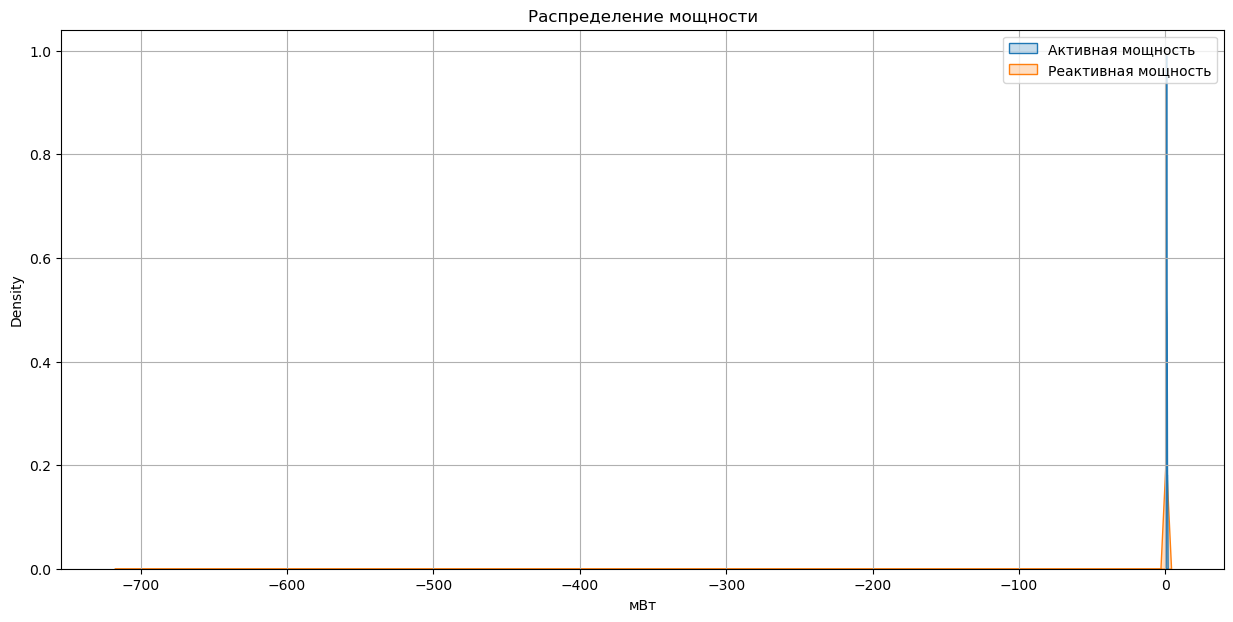

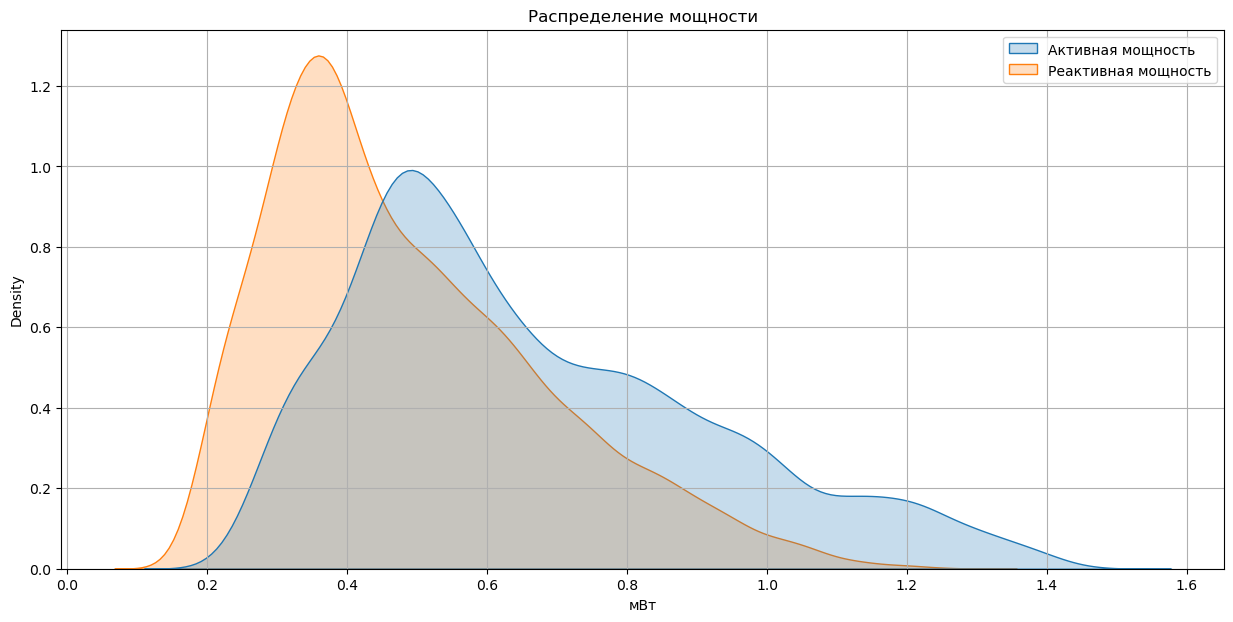

Как мы видим у реактивной мощности наблюдаются ***выбросы ввиде отрицательных значений***. На втором графике отрицательные значения исключены и мы видим равномерное распределение данных.

   * ***Данные о подаче допольнительных материалах***

Перед тем как рассмотреть данные подаче доп материалов заполним пропуски нулями.

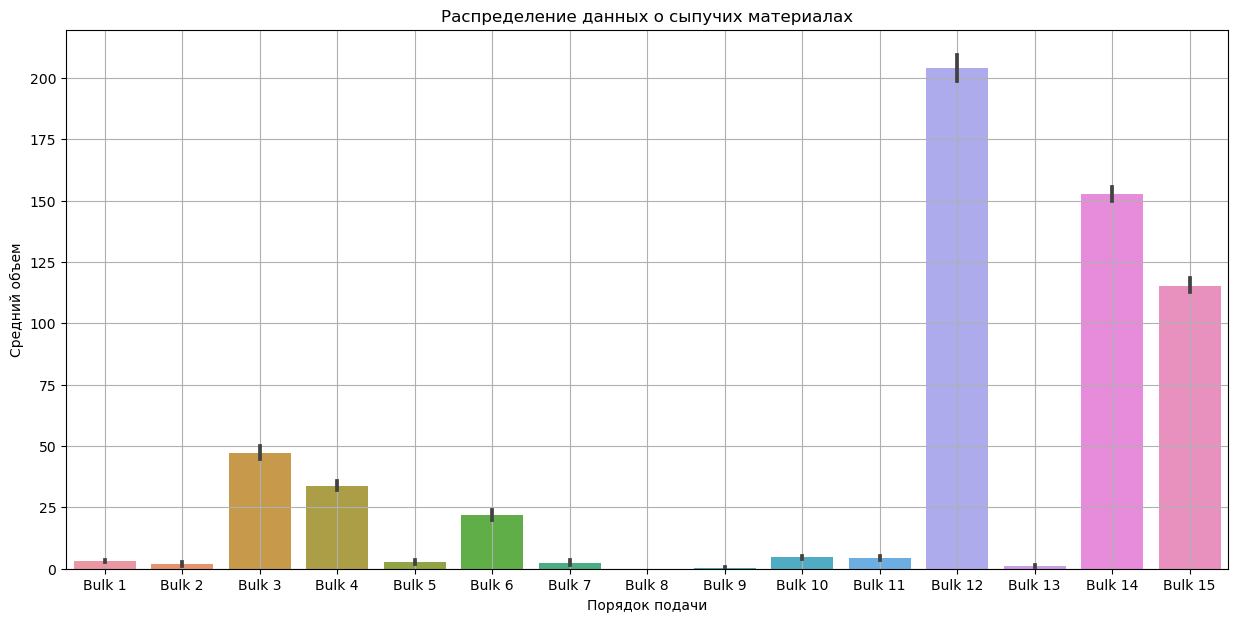

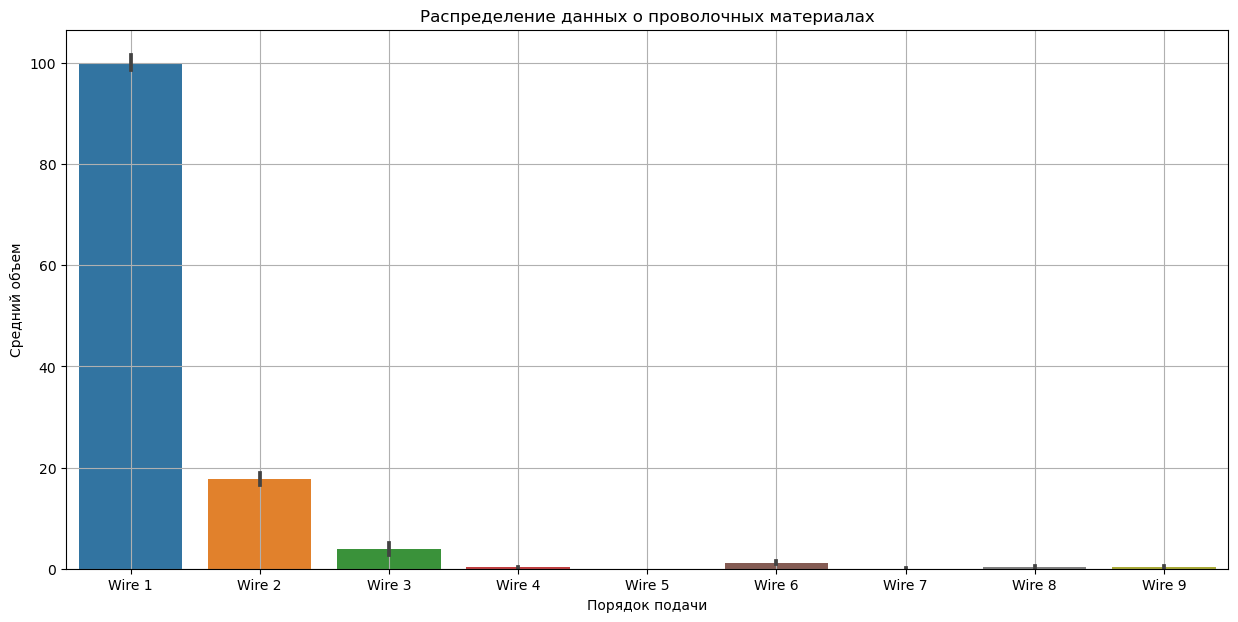

Распределение по добавкам ***нормальное***. Как мы видим в начале процесса преобладают добавки проволочного материала, а под конец процесса больше добавляют сыпучих материалов.

   * ***Данные о подаче газа***

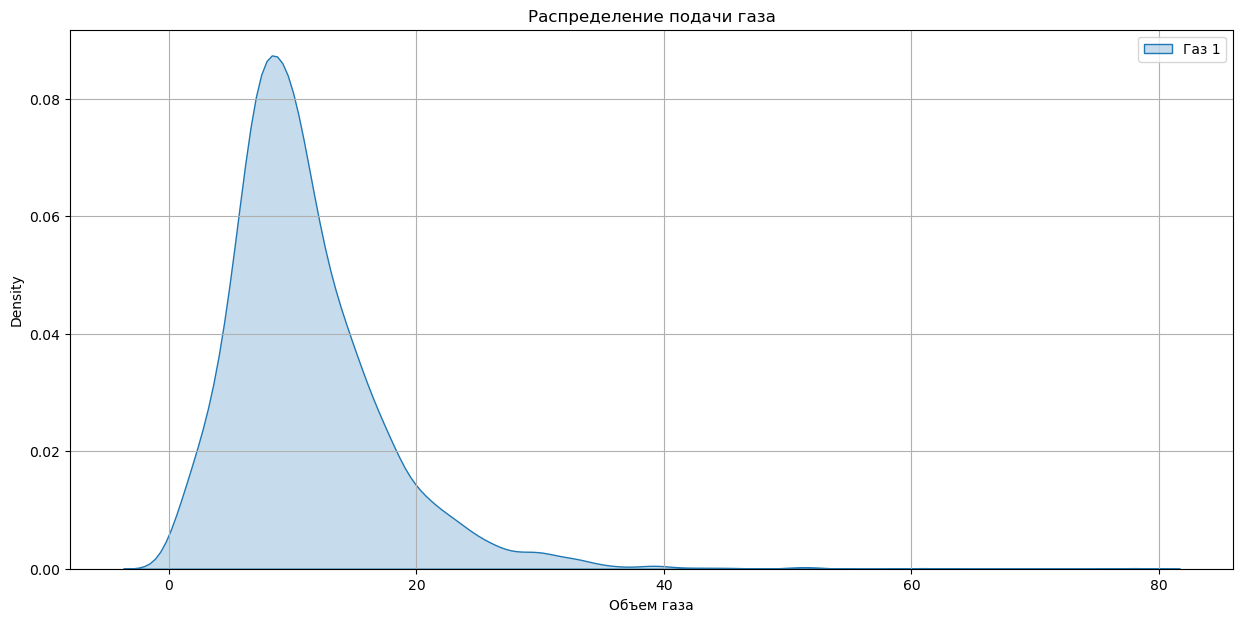

Данные распределены ***нормально***.

   * ***Данные о температуре***

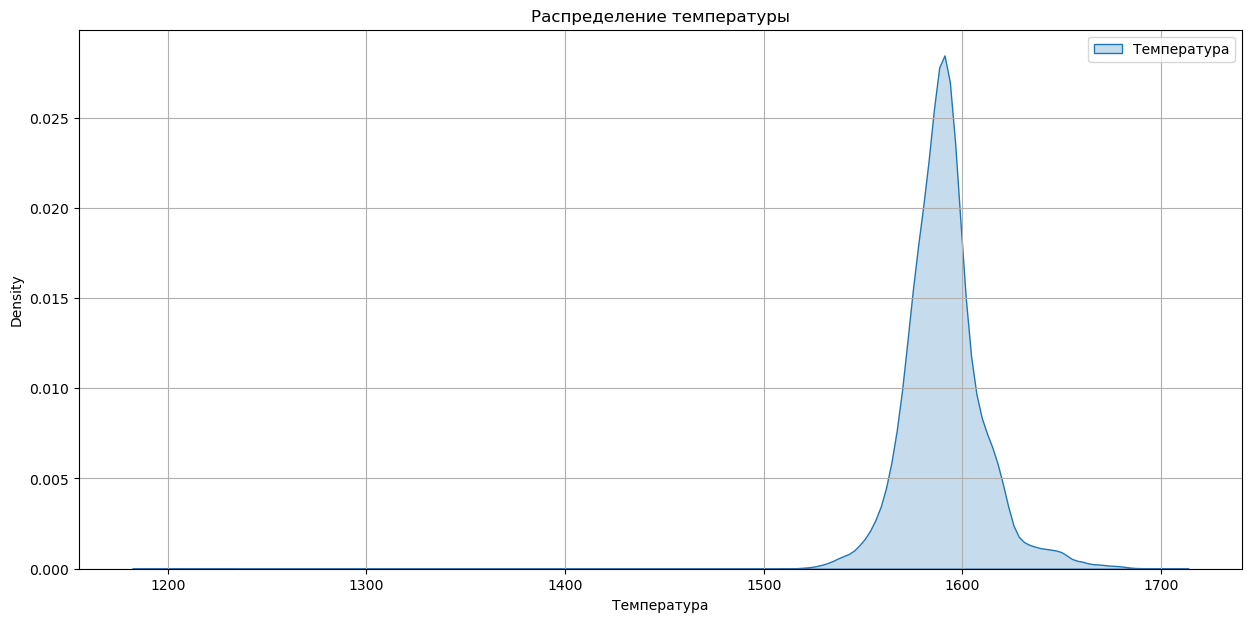

***Температура ниже 1500*** у нас быть не должно соотвественно эти данные мы ***исключаем***. Дальнейшее распределение данных нормальное.

3. ***Предобработка данных***

Создание функции для групировки по ключу.

Удаление отрицательных данных в таблице об электродах.

Перевод столбцов с временем к формату datetime и высчитывание времени в секундах на каждый замер.

По формуле считаем ***полную мощность***.

$$ S = \sqrt{P^2 + Q^2} $$

А также средние значения по полной, активной, реактивной мощности. Начальные и последние значения показаний полной, активной и реактивной мощности.

***Получившиеся данные по электродам:***

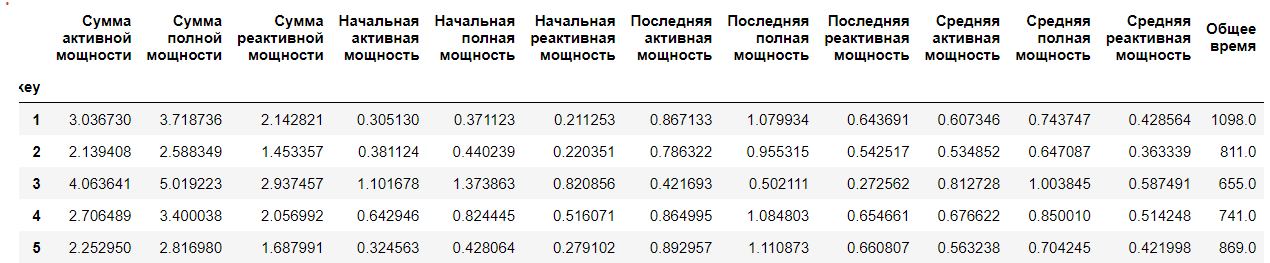

Удаление ключей с замерами ниже 1500 градусов, т.к процесс невозможен ниже данной отметки.

Подсчет количества замеров

Выделение начальной и последней температуры

Сумма температур и средняя температура

***Получившиеся данные по температуре:***


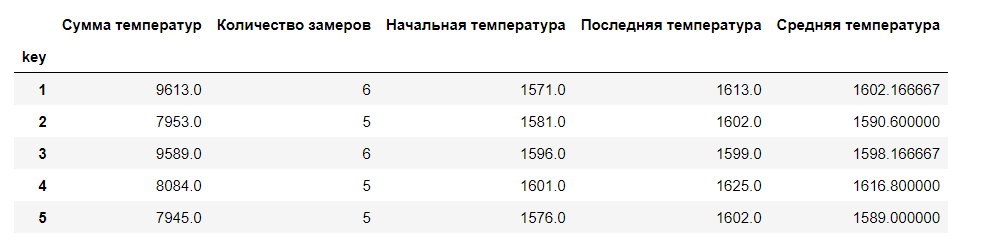

Суммирование данных по газу по ключу

Группируем по ключу данные по добавкам примесей , а также добавляем сумму добавок по ключу

***Получившиеся данные по добавкам:***

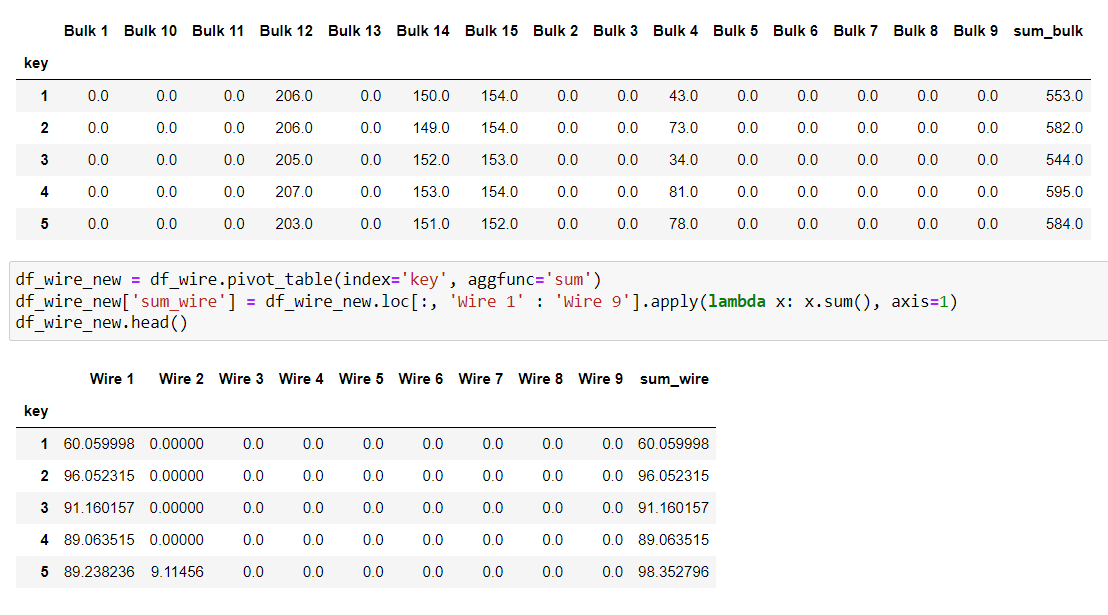

Объединение данных

***Проверка на мультиколлениарность***

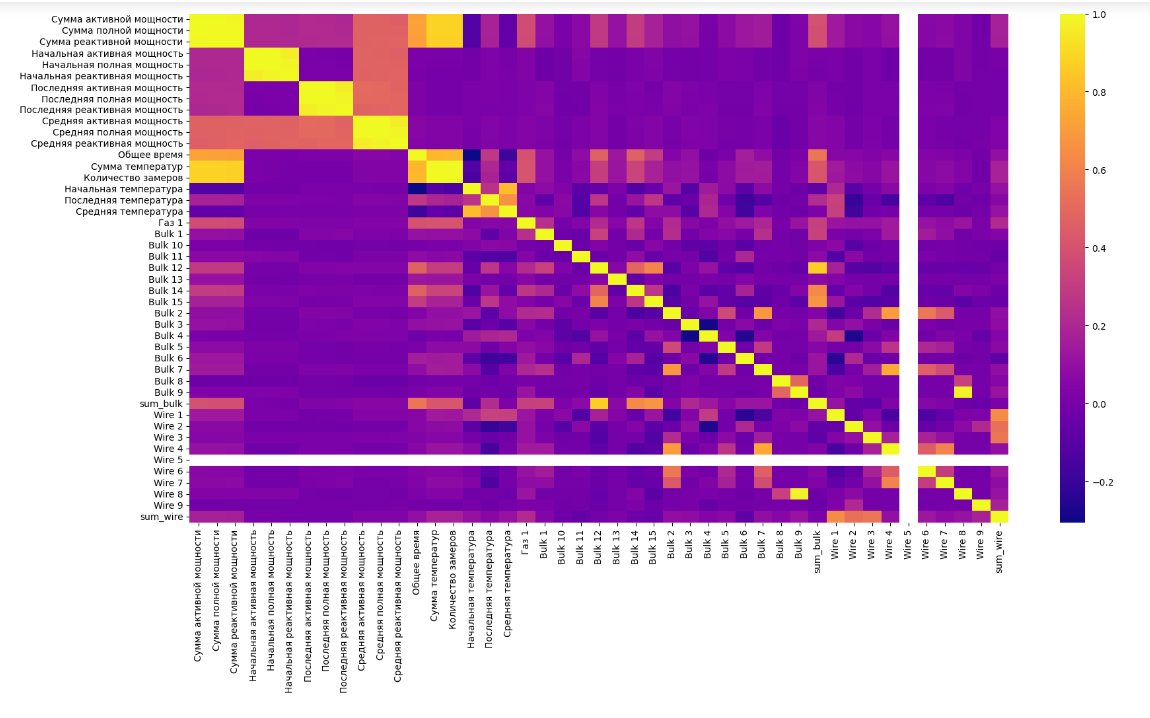

Как мы видим на целевой признак "Последняя температура" значительное влияние имеет "Средняя температура" что может привести к утечке. Также к утечке может привести "Сумма температур", т.к сумма температур включает в себя и "Последнюю температуру".



***4. Разделение на выборки***

Задаем RANDOM STATE равный 240423. Разделение на выборки обучающая 90% и тестовая 10%.  

***5. Выбор модели***

* Линейная регрессия МАЕ 6.86
* Случайный лес с помощью подбора гиперпараметров {'max_depth': None, 'max_features': 7, 'n_estimators': 200} МАЕ 6.62
* CatBoost с помощью подбора гиперпараметров {'iterations': 500, 'learning_rate': 0.03} МАЕ 6.14


***6. Тестирование***

CatBoost на тесте МАЕ 6.25

## Вывод


После завершения всего вышеперечисленного задача была решена и модель, которая предскажет температуру стали у нас работает с погрешностью всего 6.25 градусов.